# Spatio-Temporal Load Estimation and Short-Term Forecasting
Full Colab-ready notebook. Run in Google Colab.

In [2]:
import numpy as np
import pandas as pd
import os
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)


In [3]:
start = datetime(2023,1,1)
periods = 24*365*2  # 2 years hourly
dates = pd.date_range(start, periods=periods, freq='H')

df = pd.DataFrame(index=dates)
df['hour'] = df.index.hour
df['dayofweek'] = df.index.dayofweek
df['dayofyear'] = df.index.dayofyear

In [4]:
df['temp'] = 10 + 10*np.sin(2*np.pi*df['dayofyear']/365.0) + 5*np.sin(2*np.pi*df['hour']/24.0) + np.random.normal(0,1,len(df))

daily_pattern = 2 + 1.5*np.sin(2*np.pi*(df['hour']-8)/24.0)
weekly = 0.2*np.where(df['dayofweek']<5,1.0,0.8)
annual = 1 + 0.3*np.sin(2*np.pi*df['dayofyear']/365.0)

In [5]:
solar = np.maximum(0, 3*np.sin(np.pi*(df['hour']/24.0))*(1+0.5*np.sin(2*np.pi*(df['dayofyear']/365.0))))
wind = 1.5 + 0.8*np.sin(2*np.pi*(df['dayofyear']/30.0)) + np.random.normal(0,0.6,len(df))

df['solar'] = solar + np.random.normal(0,0.2,len(df))
df['wind'] = wind

base = 50*daily_pattern*weekly*annual + 0.8*(25 - df['temp']) + np.random.normal(0,2,len(df))
df['load'] = base - 0.6*df['solar'] - 0.2*df['wind']

In [6]:
for _ in range(12):
    idx = np.random.randint(0, len(df)-24)
    df.iloc[idx:idx+24, df.columns.get_loc('load')] += np.random.uniform(10,30)

df['load'] = df['load'].clip(lower=5)

In [ ]:
missing_frac = 0.05
missing_indices = np.random.choice(df.index, size=int(len(df)*missing_frac), replace=False)
df.loc[missing_indices, 'load'] = np.nan

os.makedirs('/DAA_PROJECT', exist_ok=True)
df.to_csv('/DAA_PROJECT/synthetic_load_with_missing.csv')
print("Saved synthetic dataset: /DAA_PROJECT/synthetic_load_with_missing.csv")


Saved synthetic dataset: /mnt/data/synthetic_load_with_missing.csv


In [8]:
df_interp = df.copy()
df_interp['load'] = df_interp['load'].interpolate(method='time')

df_rf = df.copy()
train_rf = df_rf[df_rf['load'].notna()]
test_rf = df_rf[df_rf['load'].isna()]

features = ['temp','solar','wind','hour','dayofweek','dayofyear']
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=1)
rf.fit(train_rf[features], train_rf['load'])
if len(test_rf)>0:
    df_rf.loc[test_rf.index, 'load'] = rf.predict(test_rf[features])
df_rf['load'] = df_rf['load'].interpolate(method='time')

df_interp.to_csv('/mnt/data/synthetic_load_imputed_interp.csv')
df_rf.to_csv('/mnt/data/synthetic_load_imputed_rf.csv')
print("Saved imputed datasets to /mnt/data (interp + RF)")

Saved imputed datasets to /mnt/data (interp + RF)


In [9]:
test_days = 30
test_period = test_days*24
train_end = df.index[-1] - pd.Timedelta(hours=test_period)
train_mask = df.index <= train_end
test_mask = df.index > train_end

data = df_rf.copy()   # use RF-imputed data for modeling
train = data[train_mask]
test = data[test_mask]
print("Train rows:", len(train), "Test rows:", len(test))

y_test_full = test['load'].values

Train rows: 16800 Test rows: 720


In [10]:
def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask]-y_pred[mask])/y_true[mask]))*100

def evaluate_forecast(y_true, y_pred):
    return {
        'MAE': mean_absolute_error(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),  # <- fixed - no squared arg
        'MAPE': mape(y_true, y_pred)
    }

In [11]:
# naive baseline: previous day same hour
def naive_forecast_series(series, horizon):
    preds = []
    for i in range(len(test)):
        t = test.index[i]
        ref = t - pd.Timedelta(hours=horizon)
        if ref in series.index:
            preds.append(series.loc[ref])
        else:
            preds.append(series.iloc[-horizon])
    return np.array(preds)

naive_pred = naive_forecast_series(data['load'], 24)

In [12]:
arima_results = {}
try:
    from statsmodels.tsa.arima.model import ARIMA
    print("Fitting ARIMA ...")
    model_arima = ARIMA(train['load'], order=(5,1,2))
    arima_fit = model_arima.fit()
    arima_pred = arima_fit.forecast(steps=len(test))
    arima_pred = pd.Series(arima_pred, index=test.index).values
    arima_results['pred'] = arima_pred
    arima_results['metrics'] = evaluate_forecast(y_test_full, arima_pred)
    print("ARIMA done.")
except Exception as e:
    print("ARIMA error:", e)

ARIMA error: No module named 'statsmodels'


In [13]:
!pip install statsmodels prophet scikit-learn pandas numpy matplotlib seaborn


   ---------------------------------------- 0.0/9.6 MB ? eta -:--:--
   ---- ----------------------------------- 1.0/9.6 MB 5.6 MB/s eta 0:00:02
   ------- -------------------------------- 1.8/9.6 MB 4.6 MB/s eta 0:00:02
   ---------- ----------------------------- 2.6/9.6 MB 4.3 MB/s eta 0:00:02
   --------------- ------------------------ 3.7/9.6 MB 4.1 MB/s eta 0:00:02
   ------------------ --------------------- 4.5/9.6 MB 4.1 MB/s eta 0:00:02
   --------------------- ------------------ 5.2/9.6 MB 4.0 MB/s eta 0:00:02
   ----------------------- ---------------- 5.8/9.6 MB 4.0 MB/s eta 0:00:01
   ---------------------------- ----------- 6.8/9.6 MB 4.0 MB/s eta 0:00:01
   -------------------------------- ------- 7.9/9.6 MB 4.0 MB/s eta 0:00:01
   ----------------------------------- ---- 8.7/9.6 MB 4.0 MB/s eta 0:00:01
   ---------------------------------------  9.4/9.6 MB 4.0 MB/s eta 0:00:01
   ---------------------------------------- 9.6/9.6 MB 3.9 MB/s  0:00:02
   -------------------

In [14]:
arima_results = {}
try:
    from statsmodels.tsa.arima.model import ARIMA
    print("Fitting ARIMA ...")
    model_arima = ARIMA(train['load'], order=(5,1,2))
    arima_fit = model_arima.fit()
    arima_pred = arima_fit.forecast(steps=len(test))
    arima_pred = pd.Series(arima_pred, index=test.index).values
    arima_results['pred'] = arima_pred
    arima_results['metrics'] = evaluate_forecast(y_test_full, arima_pred)
    print("ARIMA done.")
except Exception as e:
    print("ARIMA error:", e)

Fitting ARIMA ...


c:\Users\Shubhankar Kumar\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA done.


In [15]:
prophet_results = {}
try:
    from prophet import Prophet
    print("Fitting Prophet ...")
    prophet_df = train.reset_index().rename(columns={'index':'ds','load':'y'})[['ds','y']]
    m = Prophet(daily_seasonality=True, weekly_seasonality=True, yearly_seasonality=True)
    m.add_regressor('temp'); m.add_regressor('solar'); m.add_regressor('wind')
    prophet_train = prophet_df.copy()
    prophet_train['temp'] = train['temp'].values
    prophet_train['solar'] = train['solar'].values
    prophet_train['wind'] = train['wind'].values
    m.fit(prophet_train)
    future = test.reset_index().rename(columns={'index':'ds'})[['ds']]
    future['temp'] = test['temp'].values; future['solar'] = test['solar'].values; future['wind'] = test['wind'].values
    forecast = m.predict(future)
    prophet_pred = forecast['yhat'].values
    prophet_results['pred'] = prophet_pred
    prophet_results['metrics'] = evaluate_forecast(y_test_full, prophet_pred)
    print("Prophet done.")
except Exception as e:
    print("Prophet not available or failed:", e)

Importing plotly failed. Interactive plots will not work.


Fitting Prophet ...


16:28:46 - cmdstanpy - INFO - Chain [1] start processing
16:28:50 - cmdstanpy - INFO - Chain [1] done processing


Prophet done.


In [16]:
sarimax_results = {}
try:
    import statsmodels.api as sm
    if 'pred' not in prophet_results:
        print("Fitting SARIMAX fallback ...")
        exog_train = train[['temp','solar','wind']]
        exog_test = test[['temp','solar','wind']]
        sarimax = sm.tsa.SARIMAX(train['load'], exog=exog_train, order=(1,1,1), seasonal_order=(1,1,1,24),
                                 enforce_stationarity=False, enforce_invertibility=False)
        sarimax_fit = sarimax.fit(disp=False)
        sarimax_pred = sarimax_fit.predict(start=test.index[0], end=test.index[-1], exog=exog_test)
        # align & ffill in case of index differences
        sarimax_pred = sarimax_pred.reindex(test.index).ffill().values
        sarimax_results['pred'] = sarimax_pred
        sarimax_results['metrics'] = evaluate_forecast(y_test_full, sarimax_pred)
        print("SARIMAX done.")
except Exception as e:
    print("SARIMAX failed:", e)


In [17]:
# ------------------ 8) LSTM (TensorFlow) ------------------
lstm_results = {}
try:
    import tensorflow as tf
    from tensorflow.keras import layers, models, callbacks
    print("Preparing LSTM data ...")
    seq_len = 168
    features = ['load','temp','solar','wind','hour','dayofweek']
    arr = data[features].values
    train_arr = arr[train_mask]
    mean = train_arr.mean(axis=0); std = train_arr.std(axis=0)+1e-6
    arr_norm = (arr - mean)/std
    X, Y = [], []
    for i in range(seq_len, len(arr_norm)):
        X.append(arr_norm[i-seq_len:i]); Y.append(arr_norm[i,0])
    X = np.array(X); Y = np.array(Y)
    split_i = int(sum(train_mask)) - seq_len
    # protect against small training window
    if split_i <= 0:
        raise ValueError("Not enough training data for LSTM sequences. Increase dataset or reduce seq_len.")
    X_train, X_test = X[:split_i], X[split_i:split_i+len(test)]
    Y_train, Y_test = Y[:split_i], Y[split_i:split_i+len(test)]
    model = models.Sequential([layers.Input(shape=(seq_len, X.shape[2])), layers.LSTM(64), layers.Dense(32, activation='relu'), layers.Dense(1)])
    model.compile(optimizer='adam', loss='mse')
    cb = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    model.fit(X_train, Y_train, validation_split=0.1, epochs=15, batch_size=64, callbacks=[cb], verbose=1)
    pred_norm = model.predict(X_test).flatten()
    pred_load = pred_norm*std[0] + mean[0]
    lstm_results['pred'] = pred_load[:len(test)]
    lstm_results['metrics'] = evaluate_forecast(y_test_full, lstm_results['pred'])
    print("LSTM done.")
except Exception as e:
    print("LSTM not available or failed:", e)


Preparing LSTM data ...
Epoch 1/15
234/234 ━━━━━━━━━━━━━━━━━━━━ 16s 62ms/step - loss: 0.1991 - val_loss: 0.0783
Epoch 2/15
234/234 ━━━━━━━━━━━━━━━━━━━━ 15s 63ms/step - loss: 0.0440 - val_loss: 0.0713
Epoch 3/15
234/234 ━━━━━━━━━━━━━━━━━━━━ 16s 67ms/step - loss: 0.0424 - val_loss: 0.0695
Epoch 4/15
234/234 ━━━━━━━━━━━━━━━━━━━━ 15s 65ms/step - loss: 0.0400 - val_loss: 0.0697
Epoch 5/15
234/234 ━━━━━━━━━━━━━━━━━━━━ 16s 68ms/step - loss: 0.0416 - val_loss: 0.0676
Epoch 6/15
234/234 ━━━━━━━━━━━━━━━━━━━━ 16s 67ms/step - loss: 0.0395 - val_loss: 0.0674
Epoch 7/15
234/234 ━━━━━━━━━━━━━━━━━━━━ 15s 62ms/step - loss: 0.0404 - val_loss: 0.0691
Epoch 8/15
234/234 ━━━━━━━━━━━━━━━━━━━━ 15s 65ms/step - loss: 0.0398 - val_loss: 0.0691
Epoch 9/15
234/234 ━━━━━━━━━━━━━━━━━━━━ 15s 63ms/step - loss: 0.0394 - val_loss: 0.0697
Epoch 10/15
234/234 ━━━━━━━━━━━━━━━━━━━━ 14s 61ms/step - loss: 0.0417 - val_loss: 0.0670
Epoch 11/15
234/234 ━━━━━━━━━━━━━━━━━━━━ 15s 65ms/step - loss: 0.0393 - val_loss: 0.0680
Epoch 

In [18]:
hybrid_results = {}
try:
    # pick base
    if 'pred' in prophet_results:
        base_pred = prophet_results['pred']; base_name='prophet'
    elif 'pred' in sarimax_results:
        base_pred = sarimax_results['pred']; base_name='sarimax'
    elif 'pred' in arima_results:
        base_pred = arima_results['pred']; base_name='arima'
    else:
        base_pred = None; base_name=None

    if base_pred is not None:
        train_resid = train['load'] - train['load'].rolling(24, min_periods=1).mean()
        seq_len = 168
        features_res = ['temp','solar','wind','hour','dayofweek']
        arr_res = train[features_res].values
        y_res = train_resid.values
        mean_res = arr_res.mean(axis=0); std_res = arr_res.std(axis=0)+1e-6
        arr_res_norm = (arr_res - mean_res)/std_res
        Xr, Yr = [], []
        for i in range(seq_len, len(arr_res_norm)):
            Xr.append(arr_res_norm[i-seq_len:i]); Yr.append(y_res[i])
        Xr = np.array(Xr); Yr = np.array(Yr)
        if len(Xr) > 20:
            from tensorflow.keras import layers, models
            model_r = models.Sequential([layers.Input(shape=(seq_len, Xr.shape[2])), layers.LSTM(32), layers.Dense(16, activation='relu'), layers.Dense(1)])
            model_r.compile(optimizer='adam', loss='mse')
            model_r.fit(Xr, Yr, validation_split=0.1, epochs=8, batch_size=64, verbose=1)
            combined_features = pd.concat([train[features_res], test[features_res]])
            comb_arr = (combined_features.values - mean_res)/std_res
            X_comb = []
            for i in range(seq_len, seq_len+len(test)):
                X_comb.append(comb_arr[i-seq_len:i])
            X_comb = np.array(X_comb)
            pred_resid = model_r.predict(X_comb).flatten()
            hybrid_pred = base_pred + pred_resid[:len(test)]
            hybrid_results['pred'] = hybrid_pred
            hybrid_results['metrics'] = evaluate_forecast(y_test_full, hybrid_pred)
            print("Hybrid done (base=%s)." % base_name)
except Exception as e:
    print("Hybrid failed:", e)

Epoch 1/8
234/234 ━━━━━━━━━━━━━━━━━━━━ 12s 42ms/step - loss: 93.0986 - val_loss: 21.9238
Epoch 2/8
234/234 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - loss: 10.0534 - val_loss: 21.1935
Epoch 3/8
234/234 ━━━━━━━━━━━━━━━━━━━━ 9s 40ms/step - loss: 8.9629 - val_loss: 21.5262
Epoch 4/8
234/234 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step - loss: 9.3358 - val_loss: 20.6324
Epoch 5/8
234/234 ━━━━━━━━━━━━━━━━━━━━ 10s 43ms/step - loss: 8.9956 - val_loss: 21.0160
Epoch 6/8
234/234 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - loss: 8.8092 - val_loss: 20.7553
Epoch 7/8
234/234 ━━━━━━━━━━━━━━━━━━━━ 10s 43ms/step - loss: 8.4480 - val_loss: 20.9345
Epoch 8/8
234/234 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - loss: 8.1451 - val_loss: 20.8522
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Hybrid done (base=prophet).


In [19]:
rows = []
rows.append(('Naive(prev-day)', evaluate_forecast(y_test_full, naive_pred)))
if 'metrics' in arima_results: rows.append(('ARIMA', arima_results['metrics']))
if 'metrics' in prophet_results: rows.append(('Prophet', prophet_results['metrics']))
if 'metrics' in sarimax_results: rows.append(('SARIMAX', sarimax_results['metrics']))
if 'metrics' in lstm_results: rows.append(('LSTM', lstm_results['metrics']))
if 'metrics' in hybrid_results: rows.append(('Hybrid', hybrid_results['metrics']))

metrics_df = pd.DataFrame([{'Model': r[0], **r[1]} for r in rows]).set_index('Model')
metrics_df.to_csv('/mnt/data/forecasting_metrics_summary.csv')
print("\nMetrics summary:\n", metrics_df)



Metrics summary:
                        MAE       RMSE       MAPE
Model                                           
Naive(prev-day)   4.435457   7.473057  15.417034
ARIMA             4.088532   6.388522  13.472854
Prophet           2.756695   4.986872   9.285651
LSTM              2.063260   3.025828   7.648751
Hybrid           12.188342  13.928654  46.907026


In [20]:
threshold = 0.10
def binary_within_threshold(y_true, y_pred, thr=threshold):
    rel_err = np.abs(y_true - y_pred)/np.clip(np.abs(y_true), 1e-6, None)
    return (rel_err <= thr).astype(int)

available_preds = {'Naive': naive_pred}
if 'pred' in arima_results: available_preds['ARIMA'] = arima_results['pred']
if 'pred' in prophet_results: available_preds['Prophet'] = prophet_results['pred']
if 'pred' in sarimax_results: available_preds['SARIMAX'] = sarimax_results['pred']
if 'pred' in lstm_results: available_preds['LSTM'] = lstm_results['pred']
if 'pred' in hybrid_results: available_preds['Hybrid'] = hybrid_results['pred']

for name,pred in available_preds.items():
    # guard: ensure pred length matches test length
    if len(pred) != len(y_test_full):
        pred = np.resize(pred, len(y_test_full))
    y_bin_true = binary_within_threshold(y_test_full, y_test_full)  # all ones
    y_bin_pred = binary_within_threshold(y_test_full, pred)
    cm = confusion_matrix(y_bin_true, y_bin_pred, labels=[0,1])
    print("\nConfusion matrix for", name, "\n", cm)


Confusion matrix for Naive 
 [[  0   0]
 [333 387]]

Confusion matrix for ARIMA 
 [[  0   0]
 [368 352]]

Confusion matrix for Prophet 
 [[  0   0]
 [221 499]]

Confusion matrix for LSTM 
 [[  0   0]
 [177 543]]

Confusion matrix for Hybrid 
 [[  0   0]
 [648  72]]


In [21]:
out_df = test[['load','temp','solar','wind','hour','dayofweek']].copy().reset_index().rename(columns={'index':'ds'})
for name,pred in available_preds.items():
    if len(pred) != len(out_df):
        pred = np.resize(pred, len(out_df))
    out_df[f'pred_{name}'] = np.round(pred,4)
out_df.to_csv('/mnt/data/test_with_predictions.csv', index=False)
print("Saved outputs to /mnt/data: forecasting_metrics_summary.csv and test_with_predictions.csv")


Saved outputs to /mnt/data: forecasting_metrics_summary.csv and test_with_predictions.csv


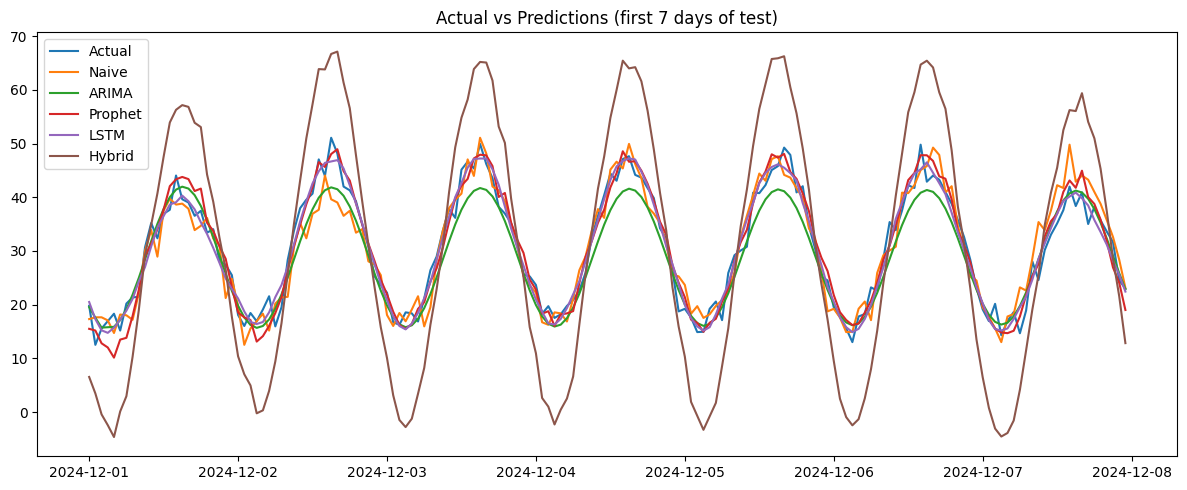

In [22]:
plt.figure(figsize=(12,5))
plt.plot(test.index[:24*7], test['load'].values[:24*7], label='Actual')
for name,pred in available_preds.items():
    plt.plot(test.index[:24*7], pred[:24*7], label=name)
plt.legend(); plt.title('Actual vs Predictions (first 7 days of test)'); plt.tight_layout()
plt.show()